### This is the implementation of linear regression with multiple features as input

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing

In [2]:
data = fetch_california_housing(as_frame=True)
df = pd.DataFrame(data.frame) # using pandas to do data operations
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [3]:
target_col = "MedHouseVal"

In [4]:
x = df.drop(columns=target_col)
y = df[target_col]
print(x.head())
print(x.columns)
print("-"*10)
print(y.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
----------
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64


### Feature Scaling

We’ll use mean Standardization (standard scaling) because it plays nicest with gradient descent.

Formula (this matters):

$
{x_{scaled}} = \frac{x-\mu}{\sigma}
$

where $\mu$ is the mean of a feature, and it helps us center all the data points around 0

example:
[2, 4, 6, 8]

Mean:

> μ = (2 + 4 + 6 + 8) / 4 = 5

Now subtract the mean from each value:

x - μ = [-3, -1, 1, 3]

* Positive = above average

* Negative = below average

> This process is called mean centering

#### Why mean-centering alone is insufficient

Consider two features:
```python
Feature A (Income):    [-3, -1, 1, 3]
Feature B (Population):[-3000, -1000, 1000, 3000]
```

Both are centered at 0, but…

* Feature B is still 1000× larger

* Gradients will still be dominated by Feature B

So we fixed offset, not scale.

#### What is standard deviation (σ)?

Standard deviation answers ONE question:

> “On average, how far is a data point from the mean?”

Think of it as spread or typical distance from normal.

Intuition:

* Low standard deviation = data points are clustered close to the mean

* High standard deviation = data points are scattered far from the mean


Lets continute from here:
x - μ = [-3, -1, 1, 3]

standard deviation for the data points:

$\sigma = \sqrt{\frac{\sum (x_i - \mu)^2}{n}}$

Let me break this down:

1. μ = mean (average) of all the data
2. (xᵢ - μ) = distance of each point from the mean
3. (xᵢ - μ)² = square each distance
4. Σ = sum all those squared distances
5. / n = divide by the number of data points (this gives you variance) - variance measure how much the data varies
6. √ = take the square root (this gives you standard deviation) - standard deviation means most points are within +/- $\sigma$ of the mean


In [5]:
# implementing standard deviation:
# formula: 

# def std(x):
#     # step 1: find the mean:
#     mu = np.mean(x)
#     # step 2: distance of each point from the mean:
#     x_mu = x - mu
#     # step 3: squaring distance to avoid negatives, and so when we take average (while calculating variance), positive and negative dont cancel each other and we end with a 0.
#     x_mu = x_mu ** 2 # squared each distance
#     #step 4: (summation of squared distance and taking diving by n) basically mean haha, then we will get variance
#     '''Variance = Mean of Squared Distances'''
#     variance = np.mean(x_mu)
#     std_dev = variance ** (1/2) # OR np.sqrt(variance)

#     return std_dev

# this implementation converts entire X (single or multiple feature into one standard deviation, but we need each std for each feature)
# hence we use axis = 0, so that it returns an array of std, in which each value is std for individual columns
def std(x):
    # step 1: find the mean:
    mu = np.mean(x, axis=0)
    # step 2: distance of each point from the mean:
    x_mu = x - mu
    # step 3: squaring distance to avoid negatives, and so when we take average (while calculating variance), positive and negative dont cancel each other and we end with a 0.
    x_mu = x_mu ** 2 # squared each distance
    #step 4: (summation of squared distance and taking diving by n) basically mean haha, then we will get variance
    '''Variance = Mean of Squared Distances'''
    variance = np.mean(x_mu, axis=0)
    std_dev = variance ** (1/2) # OR np.sqrt(variance)

    return std_dev

#### Case 1: np.mean(X) (no axis)

> np.mean(X)

NumPy flattens everything:
```python 
(2 + 4 + 6 + 1000 + 2000 + 3000) / 6 = 1002
```

One number.
You just destroyed all structure.

#### Case 2: axis=0 (THIS is the important one)

> np.mean(X, axis=0)


Think:

> “For each column, average down the rows”

Column 0:
```python 
(2 + 4 + 6) / 3 = 4
```

Column 1:
```python 
(1000 + 2000 + 3000) / 3 = 2000
```

Result:
```python 
[4, 2000]
```

👉 One mean per feature

#### Case 3: axis=1 (for contrast)

> np.mean(X, axis=1)


Think:

> “For each row, average across the columns”

Row 0:
```python 
(2 + 1000) / 2 = 501
```

Row 1:
```python 
(4 + 2000) / 2 = 1002
```

Row 2:
```python 
(6 + 3000) / 2 = 1503
```

Result:
```python 
[501, 1002, 1503]
```

👉 One mean per data point (useless for scaling)

In [ ]:
# now as we can see that the population is way larger, we need feature scaling, so that the gradient isnt affected largely cuz of one feature

# since we will be using numpy operations, lets convert these data points into numpy values

x_np = x.values
y_np = y.values

# writing the function for feature scaling (this is generally imported from sklearn) using our own std function for standard deviation
def feature_scaling(X):
    mu = np.mean(X, axis=0)       # mean per feature
    sigma = std(X)     # std per feature
    X_scaled = (X - mu) / sigma
    return X_scaled, mu, sigma

x_scaled_np, mu, sigma = feature_scaling(x_np)
print(x_scaled_np.shape)
print(x_scaled_np.shape)
# scaled data with data frame
columns = x.columns
X_scaled_df = pd.DataFrame(x_scaled_np, columns=columns)
X_scaled_df.head()

(20640, 8)
(20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818


In [7]:
# cost function for a multiple linear regression:
# the cost function would be similar to single linear regression, but the w will be replaced by w_vector and x will be replaced by x_vector.

def compute_cost(x,y,w,b):
    # here we will compute the cost J, using MSE on multi linear regression
    m,n = x.shape
    # for cost, first we need y_hat
    y_hat = np.dot(x,w) + b
    # then we need error
    error = y_hat - y
    # then we will calculate the MSE
    j_wb = (1/(2*m))* (np.sum(error ** 2))

    return j_wb

In [8]:
# now we will compute the gradient but for an entire vector
def compute_gradient(x,y,w,b):
    # gradient is the PDE of w for weight, and wrt b for bias
    # now as we know, that pde of J(w,b) w.r.t w => dj_dw = 1/m * (f_wb - y)*x
    # same for b, without x => db_dw = 1/m * (f_wb - y)
    m,n = x.shape
    f_wb = np.dot(x,w) + b
    error = f_wb - y
    dj_dw = (1/m) * np.dot(x.T, error)
    dj_db = (1/m) * np.sum(error)

    return dj_dw, dj_db

def gradient_descent(compute_cost, compute_gradient, x, y, w, b, alpha, num_iter):
    J_history = []
    w_history = []
    b_history = []
    for i in range(num_iter):
        dj_dw, dj_db = compute_gradient(x,y,w,b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        j_wb = compute_cost(x,y,w,b)
        J_history.append(j_wb)
        w_history.append(w)
        b_history.append(b)
    
    return w,b, J_history,w_history ,b_history

In [9]:
# now we will move to finding the w and b for multi linear regression:
# input data: x_scaled_np
# target values: y_np
X = x_scaled_np
y = y_np
m,n = X.shape
# initializing the w and b:
w = np.zeros(n)
b = 0
w,b,J_history, w_history, b_history = gradient_descent(compute_cost, compute_gradient, X, y, w, b, 0.01, 10000)
print(J_history[:5])
print(J_history[-5:])
print(w_history[:5])
print(w_history[-5:])

[np.float64(2.7555948588377857), np.float64(2.706946835348318), np.float64(2.6592771724427453), np.float64(2.6125659364705407), np.float64(2.5667936076425444)]
[np.float64(0.2621611560639754), np.float64(0.262161155456082), np.float64(0.2621611548487486), np.float64(0.26216115424197467), np.float64(0.26216115363575965)]
[array([ 0.00793989,  0.00121882,  0.00175337, -0.00053889, -0.00028444,
       -0.00027391, -0.00166351, -0.00053042]), array([ 0.01579443,  0.00243597,  0.0034711 , -0.00108035, -0.00056299,
       -0.00054643, -0.00331087, -0.00106755]), array([ 0.02356459,  0.00365133,  0.00515382, -0.00162413, -0.00083571,
       -0.00081757, -0.00494235, -0.0016112 ]), array([ 0.03125133,  0.00486477,  0.00680216, -0.00216994, -0.00110266,
       -0.00108732, -0.00655817, -0.0021612 ]), array([ 0.03885562,  0.00607615,  0.00841673, -0.00271756, -0.00136392,
       -0.00135569, -0.00815858, -0.00271735])]
[array([ 0.83086176,  0.11902097, -0.2678063 ,  0.3075512 , -0.00442116,
    

<Axes: >

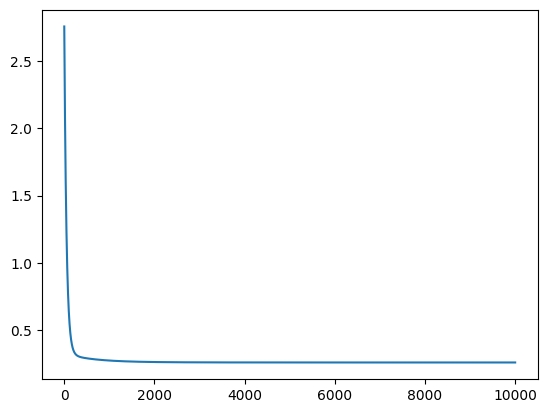

In [10]:
import seaborn as sns
sns.lineplot(J_history)


### Split the data into train test split

In [11]:
print(X.shape)
print(y.shape)

(20640, 8)
(20640,)


In [12]:
# Now we will split the data:
m = X.shape[0] # this gives the number of data points, in this case, house
indices = np.random.permutation(m) # this is to just re-arange the data points if they were linearly arranged
print(m) # 20640
split = int(0.8*m) # 16512

# actual split
train_idx = indices[:split]
test_idx  = indices[split:]

print(train_idx) # random indexes assigned (80%)
print(test_idx) # remaining 20%

# assigning these indexes to the data
x_train = X[train_idx]
y_train = y[train_idx]

x_test = X[test_idx]
y_test = y[test_idx]

20640
[20294  8281   904 ...  1461  8429 16104]
[17633 17183  2146 ... 16757 20174 17384]


In [13]:
w,b,J_history, w_history, b_history = gradient_descent(compute_cost, compute_gradient, x_train, y_train, w, b, 0.01, 10000)
train_cost = compute_cost(x_train, y_train, w, b)
train_cost

np.float64(0.26044894555791126)

In [14]:
y_test_pred = np.dot(x_test, w) + b
y_test_pred

array([3.36204221, 4.26927859, 0.99953866, ..., 2.3794016 , 2.79653023,
       2.83149622], shape=(4128,))

In [15]:
test_cost = compute_cost(x_test, y_test, w, b)
test_cost

np.float64(0.26967082003501636)

In [16]:
mse = np.mean((y_test_pred-y_test)**2)
print(mse)

0.5393416400700327


In [17]:
mse  = np.mean((y_test_pred - y_test) ** 2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_test_pred - y_test))

ss_res = np.sum((y_test - y_test_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - ss_res / ss_tot

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)

MSE : 0.5393416400700327
RMSE: 0.7343988290227815
MAE : 0.5331396392273271
R²  : 0.599917593225326
